In [ ]:
%matplotlib inline


# Circular and Elliptical Hough Transforms


The Hough transform in its simplest form is a `method to detect
straight lines <http://en.wikipedia.org/wiki/Hough_transform>`__
but it can also be used to detect circles or ellipses.
The algorithm assumes that the edge is detected and it is robust against
noise or missing points.

Circle detection
================

In the following example, the Hough transform is used to detect
coin positions and match their edges. We provide a range of
plausible radii. For each radius, two circles are extracted and
we finally keep the five most prominent candidates.
The result shows that coin positions are well-detected.


Algorithm overview
------------------

Given a black circle on a white background, we first guess its
radius (or a range of radii) to construct a new circle.
This circle is applied on each black pixel of the original picture
and the coordinates of this circle are voting in an accumulator.
From this geometrical construction, the original circle center
position receives the highest score.

Note that the accumulator size is built to be larger than the
original picture in order to detect centers outside the frame.
Its size is extended by two times the larger radius.




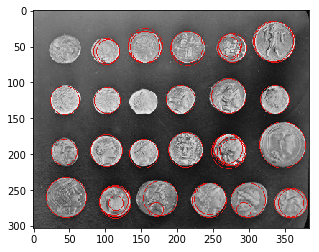

In [50]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte


# Load picture and detect edges
image = img_as_ubyte(data.coins())
edges = canny(image, sigma=2.5, low_threshold=10, high_threshold=50)


# Detect two radii
hough_radii = np.arange(10, 100, 2)
hough_res = hough_circle(edges, hough_radii)

# Select the most prominent 5 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                           total_num_peaks=40)

# Draw them
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
image = color.gray2rgb(image)
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius)
    image[circy, circx] = (220, 20, 20)

ax.imshow(image, cmap=plt.cm.gray)
# ax.imshow(edges, cmap=plt.cm.gray)
plt.show()

Ellipse detection
=================

In this second example, the aim is to detect the edge of a coffee cup.
Basically, this is a projection of a circle, i.e. an ellipse. The problem
to solve is much more difficult because five parameters have to be
determined, instead of three for circles.

Algorithm overview
-------------------

The algorithm takes two different points belonging to the ellipse. It
assumes that it is the main axis. A loop on all the other points determines
how much an ellipse passes to them. A good match corresponds to high
accumulator values.

A full description of the algorithm can be found in reference [1]_.

References
----------
.. [1] Xie, Yonghong, and Qiang Ji. "A new efficient
       ellipse detection method." Pattern Recognition, 2002. Proceedings.
       16th International Conference on. Vol. 2. IEEE, 2002



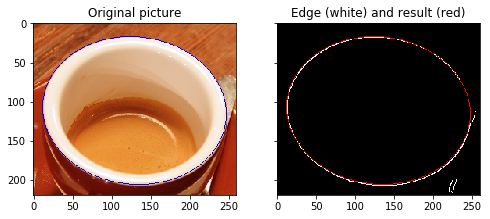

In [38]:
import matplotlib.pyplot as plt

from skimage import data, color, img_as_ubyte
from skimage.feature import canny
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter

# Load picture, convert to grayscale and detect edges
image_rgb = data.coffee()[0:220, 160:420]
image_gray = color.rgb2gray(image_rgb)
edges = canny(image_gray, sigma=2.0,
              low_threshold=0.55, high_threshold=0.8)

# Perform a Hough Transform
# The accuracy corresponds to the bin size of a major axis.
# The value is chosen in order to get a single high accumulator.
# The threshold eliminates low accumulators
result = hough_ellipse(edges, accuracy=20, threshold=250,
                       min_size=100, max_size=120)
result.sort(order='accumulator')

# Estimated parameters for the ellipse
best = list(result[-1])
yc, xc, a, b = [int(round(x)) for x in best[1:5]]
orientation = best[5]

# Draw the ellipse on the original image
cy, cx = ellipse_perimeter(yc, xc, a, b, orientation)
image_rgb[cy, cx] = (0, 0, 255)
# Draw the edge (white) and the resulting ellipse (red)
edges = color.gray2rgb(img_as_ubyte(edges))
edges[cy, cx] = (250, 0, 0)

fig2, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(8, 4), sharex=True,
                                sharey=True,
                                subplot_kw={'adjustable':'box-forced'})

ax1.set_title('Original picture')
ax1.imshow(image_rgb)

ax2.set_title('Edge (white) and result (red)')
ax2.imshow(edges)

plt.show()